## 설치

먼저, 필요한 패키지들을 설치하세요:

In [1]:
%pip install -U langgraph langsmith # % or !

  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.85
    Uninstalling langsmith-0.1.85:
      Successfully uninstalled langsmith-0.1.85
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.0.38 requires langchain-core<0.2.0,>=0.1.52, but you have langchain-core 0.2.28 which is incompatible.
langchain-experimental 0.0.58 requires langchain<0.2.0,>=0.1.17, but you have langchain 0.2.12 which is incompatible.
langchain-experimental 0.0.58 requires langchain-core<0.2.0,>=0.1.52, but you have langchain-core 0.2.28 which is incompatible.


### gpt사용을 위한 openAi API key 셋팅

In [1]:
import os
from dotenv import load_dotenv

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv()

# 환경 변수에서 OpenAI API 키를 가져옵니다.
openai_api_key = os.getenv("OPENAI_API_KEY")

# API 키가 존재하지 않는 경우 에러를 발생시킵니다.
if not openai_api_key:
    # API 키가 없다는 에러 메시지를 출력하고 프로그램을 종료합니다.
    raise ValueError("OpenAI API 키가 없습니다. 한 번 더 확인 부탁드립니다.")

## Part 1: 기본 챗봇 만들기

먼저, LangGraph를 사용하여 간단한 챗봇을 만들어 보겠습니다. 이 챗봇은 사용자 메시지에 직접 응답할 것입니다. 비록 간단하지만, LangGraph를 사용하여 챗봇을 만드는 핵심 개념을 설명할 것입니다. 이 섹션이 끝날 때쯤에는 기본적인 챗봇을 구축하게 될 것입니다.

### StateGraph 생성

StateGraph를 생성하는 것부터 시작합니다. StateGraph 객체는 챗봇의 구조를 "상태 기계"로 정의합니다. 우리는 노드를 추가하여 챗봇이 호출할 수 있는 LLM과 함수들을 나타내고, 이 함수들 간에 어떻게 전환해야 하는지를 지정할 것입니다.


In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # 메시지는 "list" 타입입니다. 주석의 `add_messages` 함수는
    # 이 상태 키가 어떻게 업데이트되어야 하는지 정의합니다.
    # (이 경우, 메시지를 덮어쓰는 대신 목록에 추가합니다.)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

그래프를 정의할 때 처음 해야 할 일은 그래프의 상태(State)를 정의하는 것입니다. 상태는 그래프의 스키마와 상태에 대한 업데이트를 적용하는 방법을 지정하는 리듀서 함수들로 구성됩니다. 우리의 예제에서 State는 단일 키 messages를 가진 TypedDict입니다. messages 키는 add_messages 리듀서 함수로 주석 처리되어 있어, LangGraph가 새 메시지를 기존 목록에 추가하도록 지시합니다. 

### 요약
이제 그래프는 두 가지를 알고 있습니다:

1. 우리가 정의하는 모든 노드는 현재 상태(State)를 입력으로 받고, 상태를 업데이트하는 값을 반환합니다.
2. 메시지는 기존 목록에 추가되며, 이는 Annotated 문법의 사전 구축된 add_messages 함수를 통해 전달됩니다.

### 노드 추가하기

우리는 이제 챗봇 노드를 추가할 것입니다. 이 노드는 사용자 메시지에 응답하는 기본 단위를 나타냅니다. 

In [12]:
from langchain_openai import ChatOpenAI
from langchain_ollama.llms import OllamaLLM

gpt = ChatOpenAI(temperature=0, model="gpt-4o-mini")
llama = OllamaLLM(model="llama3.1:8b")

def chatbot_gpt(state: State):
    return {"messages": [gpt.invoke(state["messages"])]}

def chatbot_llama(state: State):
    return {"messages": [llama.invoke(state["messages"])]}


# 첫 번째 인수는 고유한 노드 이름입니다.
# 두 번째 인수는 노드가 사용될 때 호출될 함수 또는 객체입니다.
# 노드를 사용하실수 있습니다.
# 한번 정의후 또 정의하려고하면 Node `chatbot` already present. 라는 에러를 호출합니다.
graph_builder.add_node("chatbot_gpt", chatbot_gpt)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


### LangGraph 노드 함수 패턴

챗봇 노드 함수가 현재 상태(State)를 입력으로 받아 업데이트된 메시지 목록을 반환하는 방식을 주목하세요. 이는 모든 LangGraph 노드 함수의 기본 패턴입니다.

### 메시지 추가

우리의 상태(State)에 있는 `add_messages` 함수는 LLM의 응답 메시지를 상태에 이미 있는 메시지에 추가합니다.

### 시작 지점 추가

다음으로, 시작 지점을 추가합니다. 이는 그래프가 매번 실행될 때 작업을 시작할 위치를 알려줍니다.


In [13]:
graph_builder.add_edge(START, "chatbot")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


### 종료 지점 설정

비슷하게, 종료 지점을 설정합니다. 이는 그래프에게 "이 노드가 실행될 때마다 종료할 수 있다"고 지시합니다.

In [14]:
graph_builder.add_edge("chatbot", END)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


### 그래프 실행 준비

마지막으로, 그래프를 실행할 수 있도록 설정합니다. 이를 위해 그래프 빌더에서 "compile()"을 호출합니다. 이렇게 하면 상태에서 호출할 수 있는 "CompiledGraph"가 생성됩니다.


In [15]:
graph = graph_builder.compile()

ValueError: Node `chatbot_gpt` is not reachable

### 그래프 시각화

그래프를 시각화하려면 `get_graph` 메서드와 `draw_ascii` 또는 `draw_png`와 같은 "draw" 메서드 중 하나를 사용합니다. "draw" 메서드는 각각 추가적인 종속성이 필요합니다.

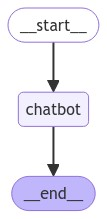

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 이제 챗봇을 실행해 봅시다!

팁: "quit", "exit", 또는 "q"를 입력하면 언제든지 채팅 루프를 종료할 수 있습니다.


In [16]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1]) # gpt사용시에는 print("Assistant:", value["messages"][-1].contents)

User:  안녕


Assistant: 안녕하세요! Nice to meet you! How can I help you today?


User:  너는 어떤 모델이니


Assistant: 나는 다양한 사람의 모습을 나타내는 모델입니다.


User:  q


Goodbye!


### LangGraph를 사용하여 첫 번째 챗봇을 만들었습니다. 
이 봇은 사용자 입력을 받아 LLM을 사용하여 응답을 생성함으로써 기본적인 대화를 할 수 있습니다. 
위 호출에 대한 LangSmith Trace를 제공된 링크에서 확인할 수 있습니다.
하지만, 봇의 지식은 훈련 데이터에 제한된다는 것을 알 수 있을 것입니다. 다음 부분에서는 웹 검색 도구를 추가하여 봇의 지식을 확장하고 더 많은 기능을 수행할 수 있도록 할 것입니다.

## Part 2: 도구를 사용하여 챗봇 강화하기

챗봇이 "기억"만으로는 답할 수 없는 질문을 처리하기 위해, 웹 검색 도구를 통합할 것입니다. 이 도구를 사용하여 봇이 관련 정보를 찾고 더 나은 응답을 제공할 수 있도록 할 것입니다.

### 요구 사항
시작하기 전에 필요한 패키지가 설치되어 있고, API 키가 설정되어 있는지 확인하세요:

먼저, [Tavily](https://tavily.com/) 검색 엔진을 사용하기 위한 요구 사항을 설치하고, `TAVILY_API_KEY`를 설정하세요.

`pip install -U langchain-community tavily-python`

In [25]:
import getpass
import os
from dotenv import load_dotenv

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv()

# 환경 변수에서 Tavily API 키를 가져옵니다.
travily_api_key = os.getenv("TRAVILY_API_KEY")

os.environ["TAVILY_API_KEY"] = travily_api_key

# API 키가 여전히 존재하지 않는 경우 에러를 발생시킵니다.
if not travily_api_key:
    raise ValueError("Tavily API 키가 없습니다. 한 번 더 확인 부탁드립니다.")


### 다음으로, 도구를 정의합니다:

In [26]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'}]

## 검색 결과 사용

결과는 챗봇이 질문에 답하기 위해 사용할 수 있는 페이지 요약입니다.

## 그래프 정의 시작

다음 단계에서는 그래프를 정의하기 시작합니다. Part 1과 동일하지만, LLM에 `bind_tools`를 추가했습니다. 이를 통해 LLM은 검색 엔진을 사용할 때 올바른 JSON 형식을 알 수 있습니다.

### 그래프 정의

이제 Part 1에서 정의한 그래프에 도구를 추가하는 방법을 살펴보겠습니다. 먼저 LLM에 도구를 바인딩하는 부분을 추가합니다.

In [27]:
from langchain_openai import ChatOpenAI
from langchain_ollama.llms import OllamaLLM



from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

gpt = ChatOpenAI(temperature=0, model="gpt-4o-mini")

def chatbot_gpt(state: State):
    return {"messages": [gpt.invoke(state["messages"])]}


# Modification: tell the LLM which tools it can call
gpt_with_tools = gpt.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [gpt_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

## 도구 실행 함수 생성

다음으로, 도구가 호출될 때 실제로 실행하는 함수를 생성해야 합니다. 이를 위해 도구를 새 노드에 추가할 것입니다.

아래는 상태에서 가장 최근의 메시지를 확인하고, 메시지에 `tool_calls`가 포함되어 있으면 도구를 호출하는 `BasicToolNode`를 구현합니다. 이는 Anthropic, OpenAI, Google Gemini 및 기타 여러 LLM 제공자의 도구 호출 지원에 의존합니다.

나중에 LangGraph의 사전 구축된 `ToolNode`로 교체하여 속도를 높이겠지만, 먼저 직접 구현해 보는 것이 유익합니다.

In [28]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## 조건부 경로 정의

도구 노드를 추가한 후에는 조건부 경로를 정의할 수 있습니다.

### 조건부 경로(Conditional Edges)

조건부 경로는 하나의 노드에서 다음 노드로의 제어 흐름을 라우팅합니다. 조건부 경로는 일반적으로 "if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅합니다. 이러한 함수는 현재 그래프 상태를 받아 다음에 호출할 노드(들)를 나타내는 문자열 또는 문자열 목록을 반환합니다.

아래에서는 챗봇의 출력에서 `tool_calls`을 확인하는 `route_tools`라는 라우터 함수를 정의합니다. 이 함수를 그래프에 제공하여, 챗봇 노드가 완료될 때마다 이 함수를 확인하여 다음 경로를 결정하도록 합니다.

조건부 경로는 `tool_calls`이 있는 경우 도구로 라우팅하고, 그렇지 않은 경우 종료 상태("__end__")로 라우팅합니다.

In [29]:
from typing import Literal

# 조건부 경로 함수 정의
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    마지막 메시지에 도구 호출이 있는지 확인하여
    조건부 경로에서 ToolNode로 라우팅합니다. 그렇지 않으면 종료 상태로 라우팅합니다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # 메시지에 tool_calls가 있는지 확인하고, 있으면 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

# `tools_condition` 함수는 챗봇이 도구를 사용하려고 할 때 "tools"를 반환하고,
# 그렇지 않으면 "__end__"를 반환합니다. 이 조건부 라우팅은 주요 에이전트 루프를 정의합니다.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # 다음 사전은 조건의 출력을 특정 노드로 해석하도록 그래프에 지시합니다.
    # 기본적으로는 동일한 이름의 노드를 사용하지만,
    # "tools" 대신 다른 이름의 노드를 사용하려면 사전 값을 업데이트하면 됩니다.
    # 예: "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)

# 도구가 호출될 때마다 챗봇으로 돌아와 다음 단계를 결정합니다.
graph_builder.add_edge("tools", "chatbot")

# 시작 상태에서 챗봇 노드로 이동합니다.
graph_builder.add_edge(START, "chatbot")

# 그래프를 컴파일합니다.
graph = graph_builder.compile()

조건부 경로는 단일 노드에서 시작합니다. 이는 그래프에게 "챗봇 노드가 실행될 때마다, 도구를 호출하면 'tools'로 이동하고, 직접 응답하면 루프를 종료하라"는 의미입니다.

사전 구축된 `tools_condition`과 마찬가지로, 우리의 함수도 도구 호출이 없는 경우 "__end__" 문자열을 반환합니다. 그래프가 "__end__"로 전환되면, 더 이상 완료할 작업이 없으므로 실행을 중지합니다. 조건이 "__end__"를 반환할 수 있기 때문에 이번에는 명시적으로 종료 지점을 설정할 필요가 없습니다. 우리의 그래프는 이미 종료할 방법을 가지고 있습니다!

이제 우리가 구축한 그래프를 시각화해봅시다. 다음 함수는 이 튜토리얼에서는 중요하지 않은 추가적인 종속성을 필요로 합니다.

### 그래프 시각화

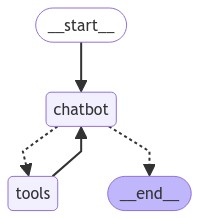

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [31]:

from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User:  안녕


Assistant: 안녕하세요! 어떻게 도와드릴까요?


User:  삼성전자 주가를 알려줘


Assistant: 
Assistant: [{"url": "https://news.tvchosun.com/site/data/html_dir/2024/07/05/2024070590099.html", "content": "\ucf54\uc2a4\ud53c 2850 \ub3cc\ud30c\u2026\uc0bc\uc131\uc804\uc790 \uc8fc\uac00 '8\ub9cc 6\ucc9c\uc6d0' \ud130\uce58. \ucf54\uc2a4\ud53c\uac00 2,850\uc120\uc744 \ub118\uc5b4\uc130\ub2e4. 5\uc77c \ud55c\uad6d\uac70\ub798\uc18c\uc5d0 \ub530\ub974\uba74 \ucf54\uc2a4\ud53c\ub294 \uc624\uc804 10\uc2dc \uae30\uc900\uc73c\ub85c 2,850\uc120\uc744 \ub3cc\ud30c\ud588\ub2e4. \ucf54\uc2a4\ud53c\ub294 2836.21\uc5d0\uc11c \ucd9c\ubc1c\ud574 \uc7a5\ucd08\ubc18 2852.59\uae4c\uc9c0 \uc0c1\uc2b9\ud588\ub2e4. 10\uc2dc 30\ubd84 \uae30\uc900\uc73c\ub85c \ucf54\uc2a4\ud53c\ub294 2,847.21\uc744 \uae30\ub85d\uc911\uc774\ub2e4 ..."}, {"url": "https://www.chosun.com/economy/money/2024/07/11/KOCI3ZFJS5BK5ML2RBFALPA33Y/", "content": "\uc0bc\uc131\uc804\uc790 \uc8fc\uac00 10\ub9cc\uc6d0 \ub3cc\ud30c\ud558\ub294 \ub0a0, \ucf54\uc2a4\ud53c\uc5d0 \uc0dd\uae38 \uc77c \ucf54\uc2a4\ud53c \uc0ac\ud758

User:  q


Goodbye!


User:  q


Goodbye!


이제 langgraph에서 검색 엔진을 사용하여 필요한 경우 최신 정보를 검색할 수 있는 대화형 에이전트를 만들었습니다. 이제 에이전트는 더 넓은 범위의 사용자 질문을 처리할 수 있습니다. 에이전트가 수행한 모든 단계를 검사하려면 이 LangSmith 추적을 확인하세요.

우리의 챗봇은 여전히 과거의 상호작용을 기억할 수 없기 때문에 일관된 다중 턴 대화를 나누는 능력이 제한됩니다. 다음 부분에서는 이 문제를 해결하기 위해 메모리를 추가할 것입니다.

이 섹션에서 만든 그래프의 전체 코드는 아래에 다시 작성되어 있으며, BasicToolNode를 사전 구축된 ToolNode로, route_tools 조건을 사전 구축된 tools_condition으로 교체했습니다.


## Part 3: 챗봇에 메모리 추가하기

이제 우리의 챗봇은 도구를 사용하여 사용자 질문에 답할 수 있지만, 이전 상호작용의 컨텍스트를 기억하지 못합니다. 이는 일관된 다중 턴 대화를 나누는 능력을 제한합니다.

LangGraph는 지속적인 체크포인팅을 통해 이 문제를 해결합니다. 그래프를 컴파일할 때 체크포인터를 제공하고, 그래프를 호출할 때 `thread_id`를 제공하면, LangGraph는 각 단계 후에 상태를 자동으로 저장합니다. 동일한 `thread_id`를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 이전 작업을 이어서 수행할 수 있습니다.

체크포인팅은 단순한 채팅 메모리보다 훨씬 강력합니다. 이는 오류 복구, 인간이 개입하는 워크플로우, 시간 여행 상호작용 등에서 복잡한 상태를 저장하고 다시 시작할 수 있게 해줍니다. 하지만 먼저, 다중 턴 대화를 가능하게 하기 위해 체크포인팅을 추가해보겠습니다.

In [39]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

`MemorySaver`:memory:`를 지정한 것을 주목하세요. 이는 모든 데이터를 메모리에 저장하기 때문에 튜토리얼에 편리합니다. 실제 응용 프로그램에서는 이를 변경하여 자신만의 데이터베이스에 연결하거나 다른 체크포인터 클래스를 사용할 가능성이 큽니다.

다음으로 그래프를 정의합니다. 이미 BasicToolNode를 직접 구축했기 때문에, 이를 LangGraph의 사전 구축된 ToolNode와 tools_condition으로 교체하겠습니다. 이들은 병렬 API 실행과 같은 유용한 기능을 제공합니다. 그 외의 부분은 모두 Part 2에서 복사한 것입니다.

In [40]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_openai import ChatOpenAI
from langchain_ollama.llms import OllamaLLM


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

마지막으로, 제공된 체크포인터와 함께 그래프를 컴파일합니다.

In [41]:
graph = graph_builder.compile(checkpointer=memory)

그래프의 연결성은 Part 2 이후로 변경되지 않았음을 주목하세요. 우리가 하는 일은 그래프가 각 노드를 처리하면서 상태(State)를 체크포인팅하는 것뿐입니다.

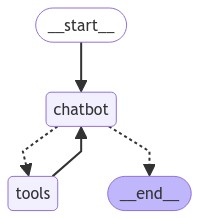

In [42]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

이제 봇과 상호작용할 수 있습니다! 먼저, 이 대화의 키로 사용할 스레드를 선택하세요.

In [43]:
config = {"configurable": {"thread_id": "1"}}

In [44]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! How can I assist you today?


참고: config는 그래프를 호출할 때 두 번째 위치 인수로 제공되었습니다. 이는 그래프 입력({ 'messages': [] }) 내에 중첩되지 않는 것이 중요합니다.

다음 질문을 해보세요: 당신의 이름을 기억하는지 확인해보세요.

In [45]:

user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will! How can I help you today?


메모리를 위해 외부 리스트를 사용하지 않는다는 점에 주목하세요: 이는 모두 체크포인터에 의해 처리됩니다! LangSmith 추적에서 전체 실행을 검사하여 무슨 일이 일어나고 있는지 확인할 수 있습니다.

믿기지 않나요? 다른 설정을 사용하여 시도해보세요.


In [46]:

# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal information or previous interactions. However, I'm here to help you with any questions or topics you'd like to discuss!


우리가 한 유일한 변경 사항은 설정(config)에서 `thread_id`를 수정한 것입니다. 비교를 위해 이 호출의 LangSmith 추적을 확인하세요.

이제 두 개의 다른 스레드에서 몇 가지 체크포인트를 만들었습니다. 하지만 체크포인트에 무엇이 들어갈까요? 주어진 설정(config)에서 그래프의 상태를 언제든지 검사하려면 `get_state(config)`를 호출하세요.

In [47]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='9f741e36-e9e1-4284-a8f7-8ae889748733'), AIMessage(content='Hi Will! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 87, 'total_tokens': 98}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-9babaaf0-3415-4ddb-aac7-aecbc94cc6a7-0', usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98}), HumanMessage(content='Remember my name?', id='3c7fe49e-6c4d-4f44-9acd-c44bab74db61'), AIMessage(content='Yes, I remember your name is Will! How can I help you today?', response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 109, 'total_tokens': 126}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_507c9469a1', 'finish_reason': 'stop', 'logprobs': None}, id='run-cde6d246-f6f4-4910-8959-8a5e4de5e792-0', usage_metadata=

In [48]:
snapshot.next  # 그래프가 이번 턴에 종료되었으므로 `next`는 비어 있습니다. 그래프 호출 중에 상태를 가져오면 next는 다음에 실행될 노드를 알려줍니다.

()

위의 스냅샷에는 현재 상태 값, 해당 설정(config), 그리고 다음에 처리할 노드가 포함되어 있습니다. 우리 경우에는 그래프가 __end__ 상태에 도달했으므로 next는 비어 있습니다.

축하합니다! 이제 LangGraph의 체크포인팅 시스템 덕분에 챗봇이 세션 간 대화 상태를 유지할 수 있게 되었습니다. 이는 보다 자연스럽고 맥락적인 상호작용을 가능하게 합니다. LangGraph의 체크포인팅은 단순한 채팅 메모리보다 훨씬 표현력이 높고 강력한 임의의 복잡한 그래프 상태도 처리할 수 있습니다.

다음 부분에서는 챗봇이 진행하기 전에 지침이나 검증이 필요한 상황을 처리하기 위해 인간의 감독을 도입할 것입니다.


## Part 4: Human-in-the-loop

에이전트는 신뢰할 수 없을 수 있으며, 작업을 성공적으로 수행하기 위해 인간의 입력이 필요할 수 있습니다. 마찬가지로, 일부 작업에 대해서는 실행하기 전에 인간의 승인을 요구하여 모든 것이 의도한 대로 실행되는지 확인하고자 할 수 있습니다.

LangGraph는 여러 가지 방법으로 human-in-the-loop 워크플로우를 지원합니다. 이 섹션에서는 LangGraph의 `interrupt_before` 기능을 사용하여 항상 도구 노드에서 중단되도록 하겠습니다.

먼저, 기존 코드에서 시작합니다. 다음은 Part 3에서 복사한 내용입니다.

In [49]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_openai import ChatOpenAI
from langchain_ollama.llms import OllamaLLM

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Now, compile the graph, specifying to interrupt_before the action node.

In [50]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [51]:

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_9eeO03nnK3BrqJkEePDX8yK4)
 Call ID: call_9eeO03nnK3BrqJkEePDX8yK4
  Args:
    query: LangGraph


그래프 상태를 검사하여 제대로 작동했는지 확인해봅시다.

In [52]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

지난번과 달리 이번에는 "next" 노드가 'action'으로 설정된 것을 확인하세요. 여기서 중단되었습니다! 이제 도구 호출을 확인해봅시다.

In [53]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_9eeO03nnK3BrqJkEePDX8yK4',
  'type': 'tool_call'}]

이 쿼리는 합리적으로 보입니다. 여기에 필터링할 것은 없습니다. 인간이 할 수 있는 가장 간단한 일은 그래프가 계속 실행되도록 하는 것입니다. 아래에서 그렇게 해보겠습니다.

다음으로, 그래프를 계속 실행하세요! `None`을 전달하면 상태에 아무것도 추가하지 않고 그래프가 중단된 위치에서 계속 실행됩니다.


In [55]:

# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with examples, integration with LangChain, and streaming support."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing ..."}]
================================== Ai Message ==================================

Here are some key resources and information about LangGraph:

1. **GitHub Reposito

축하합니다! 중단 기능을 사용하여 챗봇에 human-in-the-loop 실행을 추가하여 필요할 때 인간의 감독과 개입이 가능하도록 만들었습니다.  
이는 AI 시스템과 함께 사용할 수 있는 잠재적인 UI를 확장합니다. 이미 체크포인터를 추가했으므로,  
그래프는 무기한으로 일시 중지되고 언제든지 아무 일도 없었던 것처럼 다시 시작될 수 있습니다.
다음으로, 사용자 정의 상태 업데이트를 사용하여 봇의 동작을 더욱 맞춤화하는 방법을 탐구하겠습니다.

## Part 5: 상태 수동 업데이트

이전 섹션에서는 그래프를 중단하여 인간이 그 동작을 검사할 수 있도록 하는 방법을 보여주었습니다. 이를 통해 인간은 상태를 읽을 수 있지만, 에이전트의 경로를 변경하려면 쓰기 권한이 필요합니다.

다행히도, LangGraph는 상태를 수동으로 업데이트할 수 있게 해줍니다! 상태를 업데이트하면 에이전트의 행동을 수정하여 경로를 제어할 수 있습니다(심지어 과거도 수정할 수 있습니다!). 이 기능은 에이전트의 실수를 수정하거나, 대체 경로를 탐색하거나, 에이전트를 특정 목표로 안내하고자 할 때 특히 유용합니다.

아래에서는 체크포인팅된 상태를 업데이트하는 방법을 보여드리겠습니다. 이전과 마찬가지로, 먼저 그래프를 정의합니다. 이전에 사용한 그래프를 그대로 재사용하겠습니다.


In [58]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_openai import ChatOpenAI
from langchain_ollama.llms import OllamaLLM

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [59]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_gM6al36WEMEWjAFfNWWqr0TN)
 Call ID: call_gM6al36WEMEWjAFfNWWqr0TN
  Args:
    query: LangGraph


지금까지는 이전 섹션과 완전히 동일합니다. LLM은 검색 엔진 도구를 사용하도록 요청했으며, 우리의 그래프는 중단되었습니다. 
이전과 같이 진행하면 도구가 호출되어 웹 검색을 수행할 것입니다.
하지만 사용자가 개입하고 싶다면 어떻게 될까요? 만약 챗봇이 도구를 사용할 필요가 없다고 생각한다면요?
이제 직접 올바른 응답을 제공해봅시다!

In [60]:
from langchain_core.messages import AIMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # LLM API는 도구 호출에 대응하는 ToolMessage를 기대합니다. 여기서 이를 만족시킬 것입니다.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # 그리고 직접 LLM의 응답을 채워 넣어 "입에 말 넣기"를 합니다.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # 업데이트할 상태
    config,
    # 제공할 업데이트된 값. `State`의 메시지는 "append-only" 방식이므로 기존 상태에 추가됩니다.
    # 다음 섹션에서는 기존 메시지를 업데이트하는 방법을 검토할 것입니다!
    {"messages": new_messages},
)

print("\n\n마지막 2개의 메시지:")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


마지막 2개의 메시지:
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='c715a91e-7173-4bed-a05b-cc63c6eaf123', tool_call_id='call_gM6al36WEMEWjAFfNWWqr0TN'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='5be82100-a30d-4dda-922e-8d575c4b38df')]


이제 그래프가 완료되었습니다. 최종 응답 메시지를 제공했기 때문입니다! 상태 업데이트는 그래프의 한 단계를 시뮬레이션하므로 해당 단계에 대한 추적도 생성됩니다. 위의 `update_state` 호출에 대한 LangSmith 추적을 검사하여 어떤 일이 발생했는지 확인하세요.

새 메시지가 상태에 이미 존재하는 메시지에 추가된 것을 주목하세요. 상태 타입을 어떻게 정의했는지 기억하시나요?

```python
class State(TypedDict):
    messages: Annotated[list, add_messages]

메시지에 사전 구축된 add_messages 함수를 주석으로 추가했습니다. 이는 그래프에 값을 기존 목록에 항상 추가하도록 지시하여 목록을 직접 덮어쓰지 않게 합니다. 동일한 논리가 여기에 적용되어, 우리가 update_state에 전달한 메시지도 동일한 방식으로 추가되었습니다!

update_state 함수는 마치 그래프의 노드 중 하나인 것처럼 동작합니다! 기본적으로 업데이트 작업은 마지막으로 실행된 노드를 사용하지만, 아래에서 이를 수동으로 지정할 수 있습니다. 업데이트를 추가하고 그래프에 "chatbot"에서 온 것처럼 처리하도록 해보겠습니다.

In [61]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef554a6-bdfa-6f74-8003-e4497a3cf912'}}

제공된 링크에서 이 업데이트 호출에 대한 LangSmith 추적을 확인하세요. 추적에서 그래프가 `tools_condition` 경로로 계속되는 것을 확인할 수 있습니다. 우리는 방금 그래프에 `as_node="chatbot"`으로 업데이트를 처리하도록 지시했습니다. 아래 다이어그램을 따라 `chatbot` 노드에서 시작하면, 자연스럽게 `tools_condition` 경로로 이동한 후, 업데이트된 메시지에 도구 호출이 없으므로 __end__ 상태로 끝납니다.


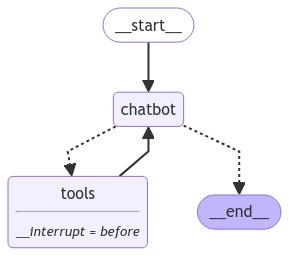

In [62]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

이전과 같이 현재 상태를 검사하여 체크포인트가 우리의 수동 업데이트를 반영하는지 확인하세요.

In [65]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='c715a91e-7173-4bed-a05b-cc63c6eaf123', tool_call_id='call_gM6al36WEMEWjAFfNWWqr0TN'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='5be82100-a30d-4dda-922e-8d575c4b38df'), AIMessage(content="I'm an AI expert!", id='4d52d5b0-ab36-4f8f-8d49-567eda20ec7c')]
()


주목하세요: 우리가 AI 메시지를 상태에 계속 추가하고 있다는 점을. 챗봇으로서 행동하고 도구 호출이 포함되지 않은 AI 메시지로 응답하고 있기 때문에, 그래프는 완료 상태에 도달했음을 인식합니다 (next가 비어 있음).

기존 메시지를 덮어쓰고 싶다면 어떻게 해야 할까요?
우리가 위에서 그래프의 상태를 주석 처리할 때 사용한 `add_messages` 함수는 메시지 키에 대한 업데이트 방법을 제어합니다. 이 함수는 새로운 메시지 목록에 있는 메시지 ID를 확인합니다. ID가 기존 상태의 메시지와 일치하면, `add_messages`는 기존 메시지를 새로운 내용으로 덮어씁니다.

예를 들어, 검색 엔진에서 좋은 결과를 얻기 위해 도구 호출을 업데이트해 봅시다! 먼저, 새로운 스레드를 시작합니다:


In [66]:

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_NaDWLFF6tH1c2VOwK9HJ663u)
 Call ID: call_NaDWLFF6tH1c2VOwK9HJ663u
  Args:
    query: LangGraph


다음으로, 에이전트의 도구 호출을 업데이트해 봅시다. 예를 들어, human-in-the-loop 워크플로우에 대해 검색하고자 할 수 있습니다.


In [67]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-a483342d-a009-4f99-9164-15f327f4a867-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_NaDWLFF6tH1c2VOwK9HJ663u', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_NaDWLFF6tH1c2VOwK9HJ663u', 'type': 'tool_call'}
Message ID run-a483342d-a009-4f99-9164-15f327f4a867-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_NaDWLFF6tH1c2VOwK9HJ663u',
  'type': 'tool_call'}]

우리가 AI의 도구 호출을 단순한 "LangGraph" 대신 "LangGraph human-in-the-loop workflow"를 검색하도록 수정한 것을 주목하세요.

LangSmith 추적을 확인하여 상태 업데이트 호출을 확인하세요. 우리의 새로운 메시지가 이전 AI 메시지를 성공적으로 업데이트한 것을 볼 수 있습니다.

기존 설정과 None 입력을 사용하여 그래프를 스트리밍하여 다시 시작하세요.

In [68]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an..."}, {"url": "https://medium.com/@kbdhunga/implementing-human-in-the-loop-with-langgraph-ccfde023385c", "content": "Implementing a Human-in-the-Loop (HIL) framework in LangGraph with the Streamlit app provides a robust mechanism for user engagement and decision-making. By incorporating breakpoints and ..."}]
================================== Ai Message ==================================

Here are some resources on LangGraph, particularly focusing on its Human-in-the-Loop (HIL) workflow:

1. **YouTube Video**: This video demonstrates how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. It shows how a human can inter

도구 호출 및 이후 LLM 응답을 확인하려면 추적을 확인하세요. 이제 그래프가 업데이트된 검색어를 사용하여 검색 엔진을 쿼리하는 것을 확인할 수 있습니다. 
우리는 여기서 LLM의 검색을 수동으로 덮어쓸 수 있었습니다!

이 모든 것은 그래프의 체크포인트된 메모리에 반영되므로, 대화를 계속하면 수정된 모든 상태를 기억할 것입니다.


In [69]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

Yes, you're learning about LangGraph, specifically its Human-in-the-Loop (HIL) workflow. If you have any specific questions or need further information on a particular aspect of LangGraph, feel free to ask!


축하합니다! `interrupt_before`와 `update_state`를 사용하여 human-in-the-loop 워크플로우의 일환으로 상태를 수동으로 수정할 수 있었습니다.
중단 및 상태 수정을 통해 에이전트의 동작을 제어할 수 있습니다. 지속적인 체크포인팅과 결합하면 작업을 일시 중지하고 언제든지 다시 시작할 수 있습니다. 
사용자가 그래프가 중단될 때 항상 사용할 수 있을 필요는 없습니다!

이 섹션의 그래프 코드는 이전과 동일합니다. 기억해야 할 중요한 부분은 그래프가 특정 노드에 도달할 때마다 명시적으로 일시 중지하려면 `.compile(..., interrupt_before=[...])` (또는 `interrupt_after`)를 추가하는 것입니다. 
그런 다음 `update_state`를 사용하여 체크포인트를 수정하고 그래프가 어떻게 진행될지를 제어할 수 있습니다.

## Part 6: 상태 맞춤화

지금까지 우리는 간단한 상태(메시지 목록)만을 사용해 왔습니다. 이 간단한 상태로도 많은 작업을 할 수 있지만, 메시지 목록에 의존하지 않고 복잡한 동작을 정의하고 싶다면 상태에 추가 필드를 추가할 수 있습니다. 
이 섹션에서는 새로운 노드를 추가하여 우리의 챗봇을 확장하고 이를 설명하겠습니다.

위의 예제에서는 항상 도구가 호출될 때마다 그래프를 중단하여 인간이 결정적으로 개입하도록 했습니다. 
만약 챗봇이 인간에게 의존할지 선택할 수 있도록 하고 싶다면 어떻게 해야 할까요?

한 가지 방법은 "human" 노드를 통과시키는 것입니다. 그래프는 이 노드 이전에 항상 중단됩니다. 
우리는 LLM이 "human" 도구를 호출할 때만 이 노드를 실행할 것입니다. 편의를 위해 그래프 상태에 "ask_human" 플래그를 포함시켜 LLM이 이 도구를 호출하면 플래그를 전환하도록 할 것입니다.

아래에, 업데이트된 상태(State)와 함께 이 새로운 그래프를 정의하세요.

In [72]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

다음으로, 모델이 도움을 요청할지 결정할 수 있도록 스키마를 정의합니다.

In [74]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """대화를 전문가에게 이관합니다. 직접 도움을 줄 수 없거나 사용자가 권한을 넘어서는 지원을 필요로 할 경우 이 기능을 사용하세요.

    이 기능을 사용하려면, 사용자의 '요청'을 전달하여 전문가가 적절한 지침을 제공할 수 있도록 합니다.
    """

    request: str

다음으로, 챗봇 노드를 정의합니다. 여기서 주요 수정 사항은 챗봇이 `RequestAssistance` 플래그를 호출했는지 확인하고 `ask_human` 플래그를 전환하는 것입니다.

In [76]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

다음으로, 그래프 빌더를 생성하고 이전과 동일하게 챗봇과 도구 노드를 그래프에 추가합니다.

In [77]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

다음으로, "human" 노드를 생성합니다. 이 노드 함수는 그래프에서 주로 인터럽트를 트리거하는 자리 표시자입니다. 인간이 인터럽트 중에 상태를 수동으로 업데이트하지 않으면, 사용자에게 요청이 있었지만 응답하지 않았음을 LLM이 알 수 있도록 도구 메시지를 삽입합니다. 이 노드는 또한 `ask_human` 플래그를 해제하여 그래프가 추가 요청이 있을 때까지 이 노드를 다시 방문하지 않도록 합니다.

In [78]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )



def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # 일반적으로 사용자가 인터럽트 중에 상태를 업데이트합니다.
        # 만약 사용자가 상태를 업데이트하지 않기로 선택한 경우,
        # LLM이 계속 실행될 수 있도록 자리 표시자 ToolMessage를 포함합니다.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # 새로운 메시지 추가
        "messages": new_messages,
        # 플래그 해제
        "ask_human": False,
    }

graph_builder.add_node("human", human_node)

다음으로, 조건부 로직을 정의합니다. `select_next_node` 함수는 플래그가 설정된 경우 `human` 노드로 라우팅합니다. 그렇지 않으면 사전 구축된 `tools_condition` 함수가 다음 노드를 선택하도록 합니다.

`tools_condition` 함수는 챗봇이 응답 메시지에서 도구 호출(tool_calls)을 응답했는지 확인합니다. 도구 호출이 있는 경우 `action` 노드로 라우팅하고, 그렇지 않으면 그래프를 종료합니다.

In [79]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

마지막으로, 간단한 방향성 경로를 추가하고 그래프를 컴파일합니다. 이러한 경로는 그래프가 노드 `a`가 실행을 마칠 때마다 항상 노드 `b`로 이동하도록 지시합니다.

In [80]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

시각화 종속성이 설치되어 있으면, 아래에서 그래프 구조를 확인할 수 있습니다:

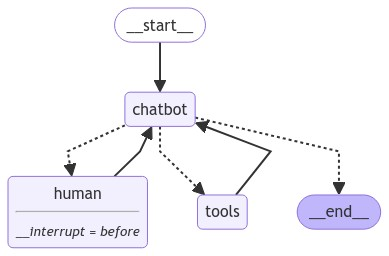

In [81]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

챗봇은 인간에게 도움을 요청(chatbot->select->human)하거나, 검색 엔진 도구를 호출(chatbot->select->action)하거나, 직접 응답(chatbot->select->end)할 수 있습니다. 작업이나 요청이 이루어진 후, 그래프는 작업을 계속하기 위해 다시 챗봇 노드로 전환됩니다.

이 그래프가 실제로 어떻게 작동하는지 확인해봅시다. 전문가의 도움을 요청하여 그래프를 설명하겠습니다.

In [82]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_Al6kAKLUSAwcD3K3HgARjg2c)
 Call ID: call_Al6kAKLUSAwcD3K3HgARjg2c
  Args:
    request: I need expert guidance on building an AI agent. I'm looking for advice on the best practices, tools, and frameworks to use, as well as any potential challenges I might face during the development process.


주목하세요: LLM이 우리가 제공한 "RequestAssistance" 도구를 호출했으며, 인터럽트가 설정되었습니다. 그래프 상태를 검사하여 이를 확인해봅시다.

In [85]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

그래프 상태는 실제로 'human' 노드 이전에 인터럽트 되었습니다. 이 시나리오에서 "전문가" 역할을 하고, 
우리의 입력을 포함한 새로운 `ToolMessage`를 추가하여 상태를 수동으로 업데이트할 수 있습니다.

In [86]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef555a3-ee4d-6dd6-8002-477d015368ce'}}

상태를 검사하여 우리의 응답이 추가되었는지 확인할 수 있습니다.


In [87]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='27f314ee-b9c5-4248-a966-d3ddd8c7e3d8'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_E5nm5seo3ntbsEnEud1bl7HT', 'function': {'arguments': '{"request":"I need expert guidance on building an AI agent. Specifically, I am looking for advice on the architecture, technologies to use, and best practices for development and deployment."}', 'name': 'RequestAssistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 176, 'total_tokens': 223}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9c494faf-c9a6-4287-85f6-1597adec9cca-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need expert guidance on building an AI agent. Specifically, I am looking for advice on the architecture, technologies t

다음으로, 입력값으로 `None`을 사용하여 그래프를 다시 실행합니다.

In [88]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I received guidance from experts suggesting that you check out **LangGraph** for building your AI agent. They mentioned that it is more reliable and extensible compared to simple autonomous agents. If you have any specific questions or need further assistance, feel free to ask!


챗봇이 최종 응답에서 업데이트된 상태를 반영한 것을 확인하세요. 모든 것이 체크포인트로 저장되었기 때문에, "전문가"가 언제든지 업데이트를 수행할 수 있었으며, 그래프의 실행에 영향을 주지 않았습니다.

축하합니다! 이제 추가적인 노드를 어시스턴트 그래프에 추가하여 챗봇이 실행을 중단해야 할지 여부를 스스로 결정할 수 있도록 했습니다. 그래프 상태에 새로운 `ask_human` 필드를 추가하고, 그래프를 컴파일할 때 인터럽션 로직을 수정하여 이를 구현했습니다. 이를 통해 그래프를 실행할 때마다 전체 메모리를 유지하면서, 루프 내에서 인간을 동적으로 포함할 수 있게 되었습니다.

튜토리얼이 거의 끝나가지만, 체크포인트와 상태 업데이트를 연결하는 한 가지 개념을 더 다루고 마치고자 합니다.

## Part 7: 시간 여행 (Time Travel)

일반적인 챗봇 워크플로우에서 사용자는 작업을 완료하기 위해 봇과 1회 이상 상호작용합니다. 이전 섹션에서는 그래프 상태를 체크포인트로 저장하고, 인간이 개입하여 상태를 수동으로 덮어써서 향후 응답을 제어하는 방법을 배웠습니다.

하지만 사용자가 이전 응답에서 시작하여 다른 결과를 탐색하고 싶다면 어떻게 될까요? 또는 사용자가 어시스턴트의 작업을 "되감기"하여 실수를 수정하거나 다른 전략을 시도하고 싶다면 어떻게 할까요? (자율 소프트웨어 엔지니어링과 같은 응용 프로그램에서 흔히 발생하는 경우)

LangGraph의 내장된 "시간 여행" 기능을 사용하여 이러한 경험을 모두 만들 수 있습니다.

이 섹션에서는 그래프의 `get_state_history` 메서드를 사용하여 체크포인트를 가져와 그래프를 "되감기"할 것입니다. 그런 다음 이 이전 시점에서 실행을 다시 시작할 수 있습니다.

먼저, 우리의 챗봇 그래프를 다시 상기해봅시다. 이전과 비교하여 변경할 필요는 없습니다:


In [89]:
from typing import Annotated, Literal


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_openai import ChatOpenAI

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # 새로운 플래그 추가
    ask_human: bool

# 전문가 도움 요청 클래스 정의
class RequestAssistance(BaseModel):
    """대화를 전문가에게 이관합니다. 직접 도움을 줄 수 없거나 사용자가 권한을 넘어서는 지원을 필요로 할 경우 이 기능을 사용하세요.

    이 기능을 사용하려면, 사용자의 '요청'을 relay하여 전문가가 적절한 지침을 제공할 수 있도록 합니다.
    """
    request: str

# 도구 설정
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")

# llm을 도구 정의, pydantic 모델, 또는 json 스키마에 바인딩
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

# 챗봇 함수 정의
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

# 그래프 빌더 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)
# 도구 노드 추가
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# 응답 생성 함수 정의
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

# 인간 노드 함수 정의
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # 일반적으로 사용자가 인터럽트 중에 상태를 업데이트합니다.
        # 만약 사용자가 상태를 업데이트하지 않기로 선택한 경우,
        # LLM이 계속 실행될 수 있도록 자리 표시자 ToolMessage를 포함합니다.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # 새로운 메시지 추가
        "messages": new_messages,
        # 플래그 해제
        "ask_human": False,
    }

# 인간 노드 추가
graph_builder.add_node("human", human_node)

# 조건부 경로 선택 함수 정의
def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # 그렇지 않으면, 이전과 같이 라우팅
    return tools_condition(state)

# 조건부 경로 추가
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

# 경로 정의
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 메모리 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

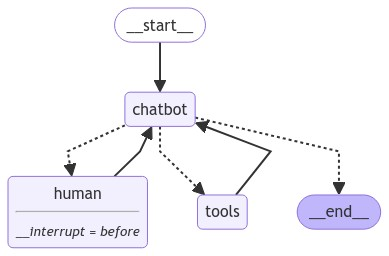

In [90]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

그래프가 몇 가지 단계를 수행하도록 해봅시다. 모든 단계는 상태 기록에 체크포인트로 저장될 것입니다.

In [91]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1RLUEpnzsx3xop4mW221Aiqh)
 Call ID: call_1RLUEpnzsx3xop4mW221Aiqh
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "LangGraph is a framework for building language agents as graphs. Learn how to use LangGraph to create chatbots, code assistants, planning agents, reflection agents, and more with these notebooks."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with examples, int

In [93]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can be a great way to explore its capabilities and learn more about language models and agent-based systems. If you have any specific ideas or features in mind for your agent, or if you need further assistance as you progress, feel free to ask. Good luck with your project!


이제 에이전트가 몇 가지 단계를 수행한 후, 전체 상태 기록을 재생하여 발생한 모든 일을 확인할 수 있습니다.

In [96]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 1:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
-----------------------------------------------

그래프의 각 단계마다 체크포인트가 저장된다는 점을 주목하세요. 이는 전체 스레드의 기록을 되돌릴 수 있도록 호출 사이에 걸쳐 저장됩니다. 
우리는 `to_replay`를 재개할 상태로 선택했습니다. 이는 위의 두 번째 그래프 호출에서 챗봇 노드 이후의 상태입니다.

이 지점에서 재개하면 다음으로 `action` 노드를 호출해야 합니다.


In [97]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef555e2-55f1-6cc4-8000-eb106a7476bf'}}


체크포인트의 설정(`to_replay.config`)에 `thread_ts` 타임스탬프가 포함된 것을 주목하세요. 이 `thread_ts` 값을 제공하면 LangGraph의 체크포인터는 해당 시점의 상태를 로드합니다. 아래에서 이를 시도해 봅시다:

In [98]:
# `to_replay.config`의 `thread_ts`는 우리가 체크포인터에 저장한 상태에 해당합니다.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1RLUEpnzsx3xop4mW221Aiqh)
 Call ID: call_1RLUEpnzsx3xop4mW221Aiqh
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "LangGraph is a framework for building language agents as graphs of nodes and edges. Learn how to use LangGraph to create chatbots, code assistants, multi-agent systems, planning agents, and more with these notebooks."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. It integrates with LangChain and LangSmith, and supports streaming, human-in-the-loop, and memory features."}]
================================== Ai Message ============

그래프가 **action** 노드에서 실행을 재개한 것을 확인하세요. 이는 위에서 출력된 첫 번째 값이 검색 엔진 도구의 응답이기 때문에 알 수 있습니다.

축하합니다! 이제 LangGraph에서 시간 여행 체크포인트 탐색을 사용했습니다. 되감기 및 대체 경로 탐색 기능은 디버깅, 실험 및 대화형 애플리케이션에 무한한 가능성을 열어줍니다.

## 결론

축하합니다! 소개 튜토리얼을 완료하고 LangGraph에서 도구 호출, 지속적 메모리, human-in-the-loop 상호작용, 심지어 시간 여행까지 지원하는 챗봇을 구축했습니다!
